In [5]:
# import required libraries
import warnings
warnings.filterwarnings("ignore")

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [7]:
import re
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

In [8]:
import tensorflow as tf 

In [9]:
data_dir = "./train_val/"

In [10]:
# get to know whats inside the data
os.listdir(data_dir)

['train', 'val']

In [11]:
# initialize image sizes and parameters
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 32

In [12]:
os.listdir(data_dir + "train")

['healthy_wheat', 'leaf_rust', 'stem_rust']

In [13]:
# a function to show the image batch
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [14]:
# get the number of images
train_image_count = len(list(Path(data_dir + "train").glob('*/*')))
val_image_count = len(list(Path(data_dir + "val").glob('*/*')))
print(train_image_count)
val_image_count

699


177

In [78]:
# train data
train_list_ds = tf.data.Dataset.list_files(str(data_dir + "train/" +'*/*'))
# validation data
val_list_ds = tf.data.Dataset.list_files(str(data_dir + "val/" +'*/*'))

In [16]:
# images class names
CLASS_NAMES = np.array([item.name for item in Path(data_dir + "train").glob('*')])
CLASS_NAMES

array(['healthy_wheat', 'leaf_rust', 'stem_rust'], dtype='<U13')

In [17]:
# check the images file paths
for f in train_list_ds.take(5):
  print(f.numpy())

b'.\\train_val\\train\\stem_rust\\H1ZJPM.JPG'
b'.\\train_val\\train\\stem_rust\\SR3XX6.jpg'
b'.\\train_val\\train\\leaf_rust\\GTGORY.jpg'
b'.\\train_val\\train\\stem_rust\\J4FNMC.jpg'
b'.\\train_val\\train\\healthy_wheat\\SVTYF9.jpg'


In [18]:
# read image 
# a function to read data
def read_image(img_path):
    img_loader = tf.io.read_file(img_path)
    img_decoder = tf.image.decode_jpeg(img_loader, channels=CHANNELS)
    img = tf.image.convert_image_dtype(img_decoder, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])
    # img = img/255.0 # rescale images
    return img

In [19]:
# To get labels
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

In [20]:
# process paths
def process_path(file_path):
    label = get_label(file_path)
    label = tf.cast(label, tf.int32)
    img = read_image(file_path)
    return img, label

In [21]:
# using tensorflow dataset.map to create a dataset of image, label pairs
train_labeled_ds = train_list_ds.map(process_path, num_parallel_calls=-1)
val_labeled_ds = val_list_ds.map(process_path, num_parallel_calls=-1)

In [22]:
for image, label in val_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  0


In [23]:
# prepare data for training 
def prepare_for_training(ds, shuffle_buffer_size=100, training=True):
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  if training:
    ds = ds.repeat()
    print("repeating")
  else:
    pass
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=-1)

  return ds

In [26]:
train_ds = prepare_for_training(train_labeled_ds)
val_ds = prepare_for_training(val_labeled_ds, training=False)

# get some data
image_batch, label_batch = next(iter(train_ds))

repeating


IndexError: index 0 is out of bounds for axis 0 with size 0

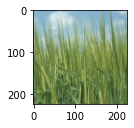

In [27]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [28]:
test_list = "./test/"

In [29]:
test_list_ds = tf.data.Dataset.list_files(str(test_list +'*/*'))

In [30]:
# test list file names
for f in test_list_ds.take(5):
  print(f.numpy())

b'.\\test\\test\\F0BMJU.jfif'
b'.\\test\\test\\S7GZWC.jfif'
b'.\\test\\test\\4J0AQ2.JPG'
b'.\\test\\test\\26MSDN.jpg'
b'.\\test\\test\\Y7VVJU.jfif'


In [31]:
# process test
def process_test(image_path):
    img = read_image(image_path)
    return img, image_path

In [32]:
test_ds = test_list_ds.map(process_test, num_parallel_calls=-1)

(224, 224, 3)
b'.\\test\\test\\F0BMJU.jfif'


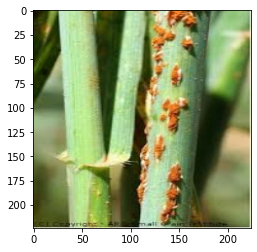

In [33]:
for i, j in test_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy())
    plt.imshow(i.numpy())

In [34]:
# temsorboard
log_dir="logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Early stopping
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# model checkpoints
checkpoint_path =  "model/" + datetime.now().strftime("%Y%m%d-%H%M%S") + "/cp.ckpt"
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
            checkpoint_path,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_categorical_accuracy',
            mode='max')

In [45]:
callbacks = [tensorboard, es]

In [55]:
logdir = os.path.join('cnn_selu_callbacks')

In [56]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)]

In [57]:
# define class weights
leaf_rust_count = len(os.listdir(data_dir + "train/leaf_rust"))
stem_rust_count = len(os.listdir(data_dir + "train/stem_rust"))
healthy_wheat_count =len(os.listdir(data_dir + "train/healthy_wheat"))
total = leaf_rust_count + stem_rust_count + healthy_wheat_count

leaf_rust_weight = (1/leaf_rust_count) * (total) / 3.0
stem_rust_weight = (1/stem_rust_count) * (total) / 3.0
healthy_wheat_weight = (1/healthy_wheat_count) * (total) / 3.0

class_weight = {0:leaf_rust_weight, 1:stem_rust_weight, 2:healthy_wheat_weight}
print(class_weight)

{0: 0.8146853146853147, 1: 0.7766666666666667, 2: 2.061946902654867}


In [58]:
def simple_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32 ,(3,3), activation="relu", 
                padding="same", input_shape=(224,224, 3)))
    model.add(tf.keras.layers.MaxPool2D(2,2, padding="same"))
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), 
                    loss=tf.keras.losses.categorical_crossentropy, 
                    metrics = [tf.keras.metrics.categorical_accuracy])
    return model 

In [59]:
steps_per_epoch = train_image_count // BATCH_SIZE
validation_steps = val_image_count // BATCH_SIZE
print(steps_per_epoch)
validation_steps

21


5

In [60]:
# fit the model
model = simple_model()

In [61]:
import datetime

In [62]:
model.fit(train_ds, epochs=1000, steps_per_epoch=steps_per_epoch, 
                validation_data=val_ds, validation_steps=validation_steps,
                callbacks=callbacks, class_weight=class_weight)

Epoch 1/1000
21/21 [==============================] - 85s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3646 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.4313
Epoch 2/1000
21/21 [==============================] - 79s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3765 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.4313
Epoch 3/1000
21/21 [==============================] - 89s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3557 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.4313
Epoch 4/1000
21/21 [==============================] - 82s 4s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3780 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.4313
Epoch 5/1000
21/21 [==============================] - 70s 3s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3869 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.4313
Epoch 6/1000
21/21 [==============================] - 63s 3s/step - loss: 0.0000e+00 - categorical_accuracy: 0.3676 - val_loss: 0.

KeyboardInterrupt: 

In [63]:
# test count
test_count = len(list(Path(test_list).glob('*/*')))
test_count

610

In [64]:
names = []
preds = []

In [65]:
for i, j in tqdm(test_ds):
    i = i.numpy()[np.newaxis, :] # add a new dimension
    prediction = model.predict_proba(i) # make predictions
    preds.append(prediction) 
    
    # use regular expressions to extract the name of image
    name = j.numpy()
    name = re.sub("[^A-Z0-9]", "", str(name))
    name = name.replace("JPG", "")
    name = name.replace("PNG", "")
    name = name.replace("JPEG", "")
    name = name.replace("JFIF", "")
    names.append(name)
    # break

610it [00:50, 12.17it/s]


In [66]:
# create a dummy dataset
leaf_rust = pd.Series(range(610), name="leaf_rust", dtype=np.float32)
stem_rust = pd.Series(range(610), name="stem_rust", dtype=np.float32)
healthy_wheat = pd.Series(range(610), name="healthy_wheat", dtype=np.float32)

In [67]:
sub = pd.concat([leaf_rust, stem_rust, healthy_wheat], axis=1)

In [68]:
sub.shape

(610, 3)

In [69]:
# append real predictions to the dataset
for i in tqdm(range(0 ,len(preds))):
    sub.loc[i] = preds[i]
    # break    

100%|██████████████████████████████████████████████████████████████████████████████| 610/610 [00:00<00:00, 2904.78it/s]


In [70]:
sub.head()

,leaf_rust,stem_rust,healthy_wheat
0,0.375249,0.385842,0.238910
1,0.370928,0.374664,0.254408
2,0.400215,0.377953,0.221831
3,0.364660,0.375101,0.260239
4,0.373243,0.389262,0.237496


In [71]:
sub["ID"] = names

In [72]:
sub.tail()

,leaf_rust,stem_rust,healthy_wheat,ID
605,0.374849,0.380601,0.244550,27CXW6
606,0.374652,0.387635,0.237713,ZKF0L9
607,0.390357,0.384024,0.225619,LB8UML
608,0.373693,0.381876,0.244431,PW2MCN
609,0.382183,0.382193,0.235624,3RITFB


In [73]:
cols = sub.columns.tolist()

In [75]:
cols = cols[-1:] + cols[:-1]
sub = sub[cols]

In [76]:
sub.head()

,ID,leaf_rust,stem_rust,healthy_wheat
0,F0BMJU,0.375249,0.385842,0.238910
1,S7GZWC,0.370928,0.374664,0.254408
2,4J0AQ2,0.400215,0.377953,0.221831
3,26MSDN,0.364660,0.375101,0.260239
4,Y7VVJU,0.373243,0.389262,0.237496


In [77]:
# write to csv
sub.to_csv("sub.csv", index=False)